In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")
vs_uncert_data = surfvel_data_40kms["vs_uncert"].data

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(12, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1

log_c_slide_init = np.log10(13.5)*np.ones((JMAX+1, IMAX+1))
# log_c_slide_init = np.log10(100.0)*np.ones((JMAX+1, IMAX+1))

dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init}
dict_params_fields_num_dims = {"xx_c_slide_init": "2D"}
dict_params_coords = {"time_ad": time_ad,
               "zeta_c": exp_sigma_level,
               "y": yModel40,
               "x": xModel40}
dict_params_attrs_type = {"xx_c_slide_init": "nodiff"}
dict_params_fields_or_scalars = {"xx_c_slide_init": "field"}
dict_masks_observables = {"vs": vs_uncert_data**(-2)}

prior_alpha = 1.0
prior_delta_z_scaler = 1.0
dict_prior_sigmas = {"xx_c_slide_init": None}
dict_prior_gammas = {"xx_c_slide_init": 1000.0}
dict_prior_deltas = {"xx_c_slide_init": 1.0}

MAX_ITERS_SOR = 100
OMEGA_SOR = 1.5

In [4]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

DA.copy_dir(sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff.nc",
            sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff_prior.nc")

ds_prior = xr.open_dataset(sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff_prior.nc")
ds_prior["prior_alpha"] = xr.DataArray([prior_alpha], dims=["scalar"], attrs={"type": "hyperparameter_prior"})
ds_prior["prior_delta_z_scaler"] = xr.DataArray([prior_delta_z_scaler], dims=["scalar"], attrs={"type": "hyperparameter_prior"})

# ds_prior["xx_c_slide_init"].data = ds_prior["xx_c_slide_init"].data*0.0 + np.log10(13.5)

# Ensure the sequence in these arrays is the same as defined in ad_specs.h
ds_prior["genarr2d_gamma_arr"] = xr.DataArray([dict_prior_gammas["xx_c_slide_init"]], dims=["genarr2d"], attrs={"type": "hyperparameter_prior"})
ds_prior["genarr2d_delta_arr"] = xr.DataArray([dict_prior_deltas["xx_c_slide_init"]], dims=["genarr2d"], attrs={"type": "hyperparameter_prior"})

DA.remove_dir(sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff_prior.nc")
ds_prior.to_netcdf(sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff_prior.nc")

In [5]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
ds_x_tlm_only = DA.subset_of_ds(ds_x, "type", "tlm")
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(1332054.7890490885, 1332054.7890601745)

In [6]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(1332054.7890490885, 1332054.7890601745)

In [7]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_Cx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_adj_action_or_tlm_action = "tlm_action")
ds_A_Cx = DA.eval_tlm_action()
ds_noise_cov_inv_A_Cx = DA.eval_noise_cov_inv_action(ds_A_Cx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_C_H_misfit_Cx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_Cx, ds_noise_cov_inv_A_Cx], ["tlmhessaction", "adjhessaction"])

(117007.94670145476, 117007.94670303412)

In [8]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_Cx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_adj_action_or_tlm_action = "tlm_action")
ds_C_inv_Cx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_C_inv_Cx, ds_C_inv_Cx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"])

(3033.1976707449985, 3033.1976707449994)

In [9]:
DA.l2_inner_product([ds_Cx, ds_Cx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"])

(433.87045808553876, 3033.1976707449994)

In [10]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_C_H_Cx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]) + DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x_tlm_only, ds_C_H_Cx], ["tlm", "adj"])

(117007.94670145476, 120041.14437219975, 120041.14437219975)

---------------------------------------------------------------------------------------------------------------
iter 0, fc = 124351.25048805274, fc_data = 124351.25048805274, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.00048828125
---------------------------------------------------------------------------------------------------------------
iter 1, fc = 36872.14759711659, fc_data = 4622.484358589427, fc_reg = 32249.66323852717
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.03125
---------------------------------------------------------------------------------------------------------------
iter 2, fc = 36407.14656305348, fc_data = 3955.208335255112, fc_reg = 32451.938227798368
---------------------------------------------------------------------------------------------------------------
Step size alpha =

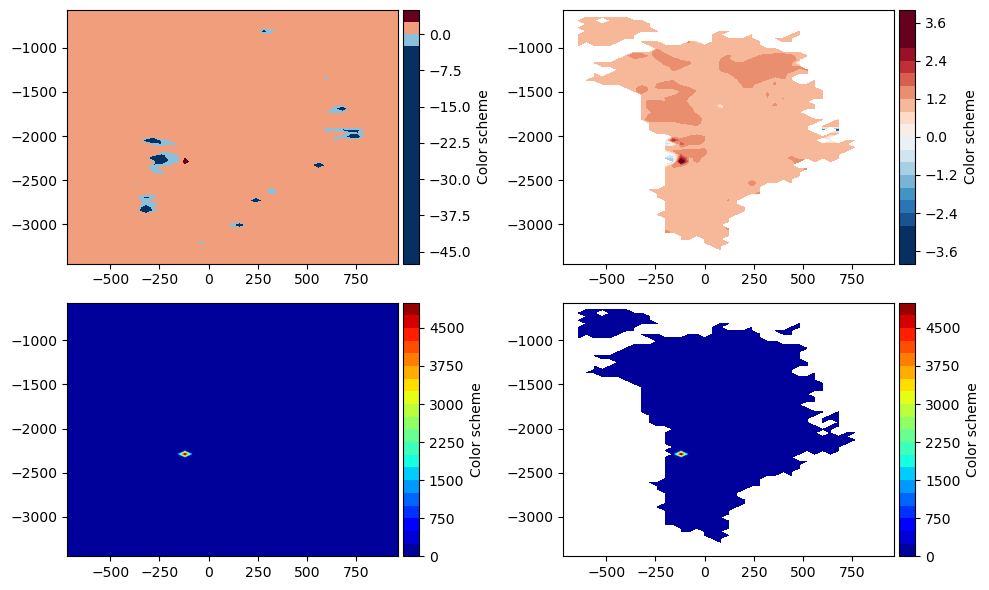

In [11]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds = DA.gradient_descent(5, init_alpha = 1.0, min_alpha_tol = 1.e-10)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (10,6)
fig, ax = plt.subplots(2, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -3, vmax = 3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -3, vmax = 3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
plt.tight_layout()

---------------------------------------------------------------------------------------------------------------
Initial fc = 124351.25048805274, fc_data = 124351.25048805274, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 31880.604051894436, norm_r_hat: 25537.284089979694
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  180.0
Step size alpha = 1.0
---------------------------------------------------------------------------------------------------------------
Outer iter 1, fc = 34257.98445523955, fc_data = 34253.21269180304, fc_reg = 4.771763436510681
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 7458.331836117203, norm_r_hat: 5540.457254993708
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  180.0
Step size alpha = 1.0
------------------------------

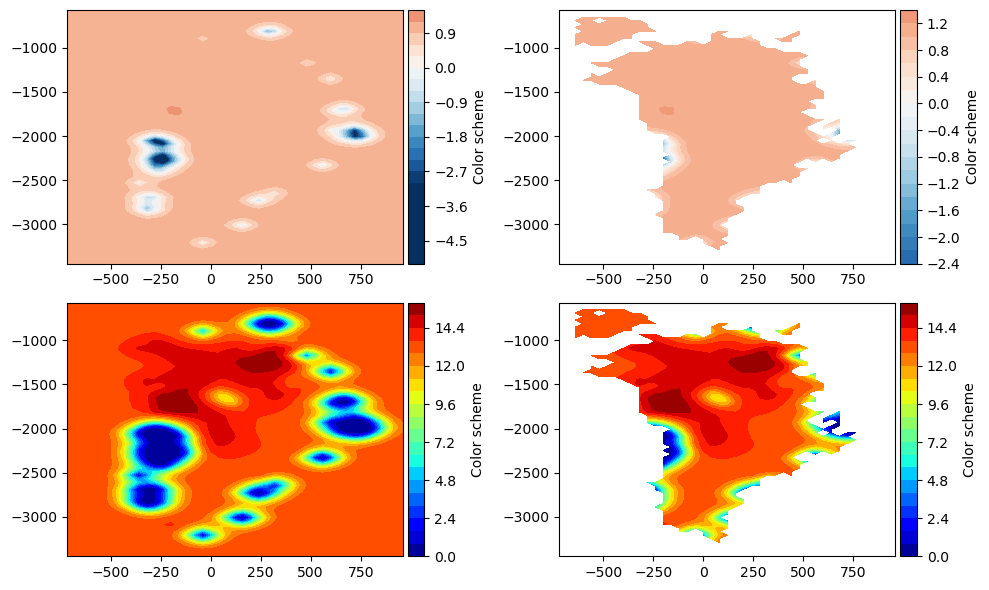

In [12]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds = DA.inexact_gn_hessian_cg(MAX_ITERS=5, init_alpha_gd = 1.e-6)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (10,6)
fig, ax = plt.subplots(2, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -3, vmax = 3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -3, vmax = 3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
plt.tight_layout()

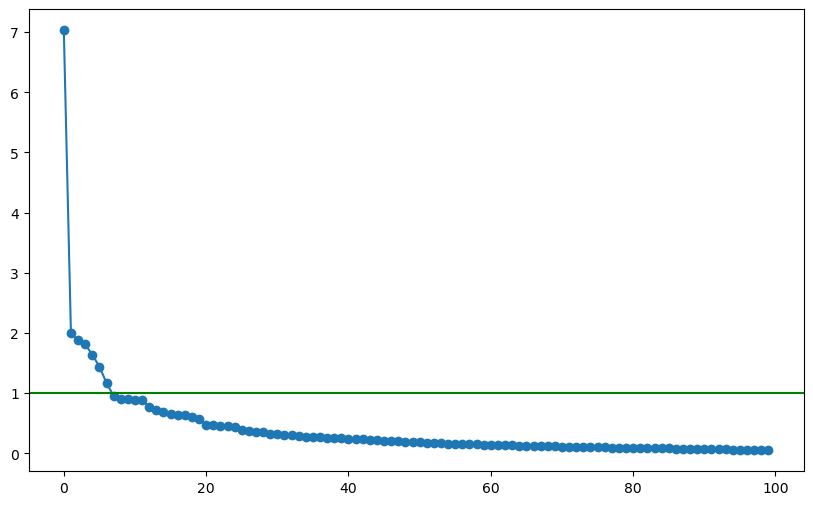

In [13]:
U_misfit, Lambda_misfit = DA.revd(95, 5, mode = "misfit_prior_precond")

plt.scatter(np.arange(Lambda_misfit.shape[0]), np.sort(Lambda_misfit)[::-1])
plt.plot(np.sort(Lambda_misfit)[::-1])

plt.axhline(1, color = "green")

In [14]:
sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared = DA.forward_uq_propagation(U_misfit, Lambda_misfit)
sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared

(2.5319065126598487e+18, 9.716286155246355e+17, 0.6162462513262749)

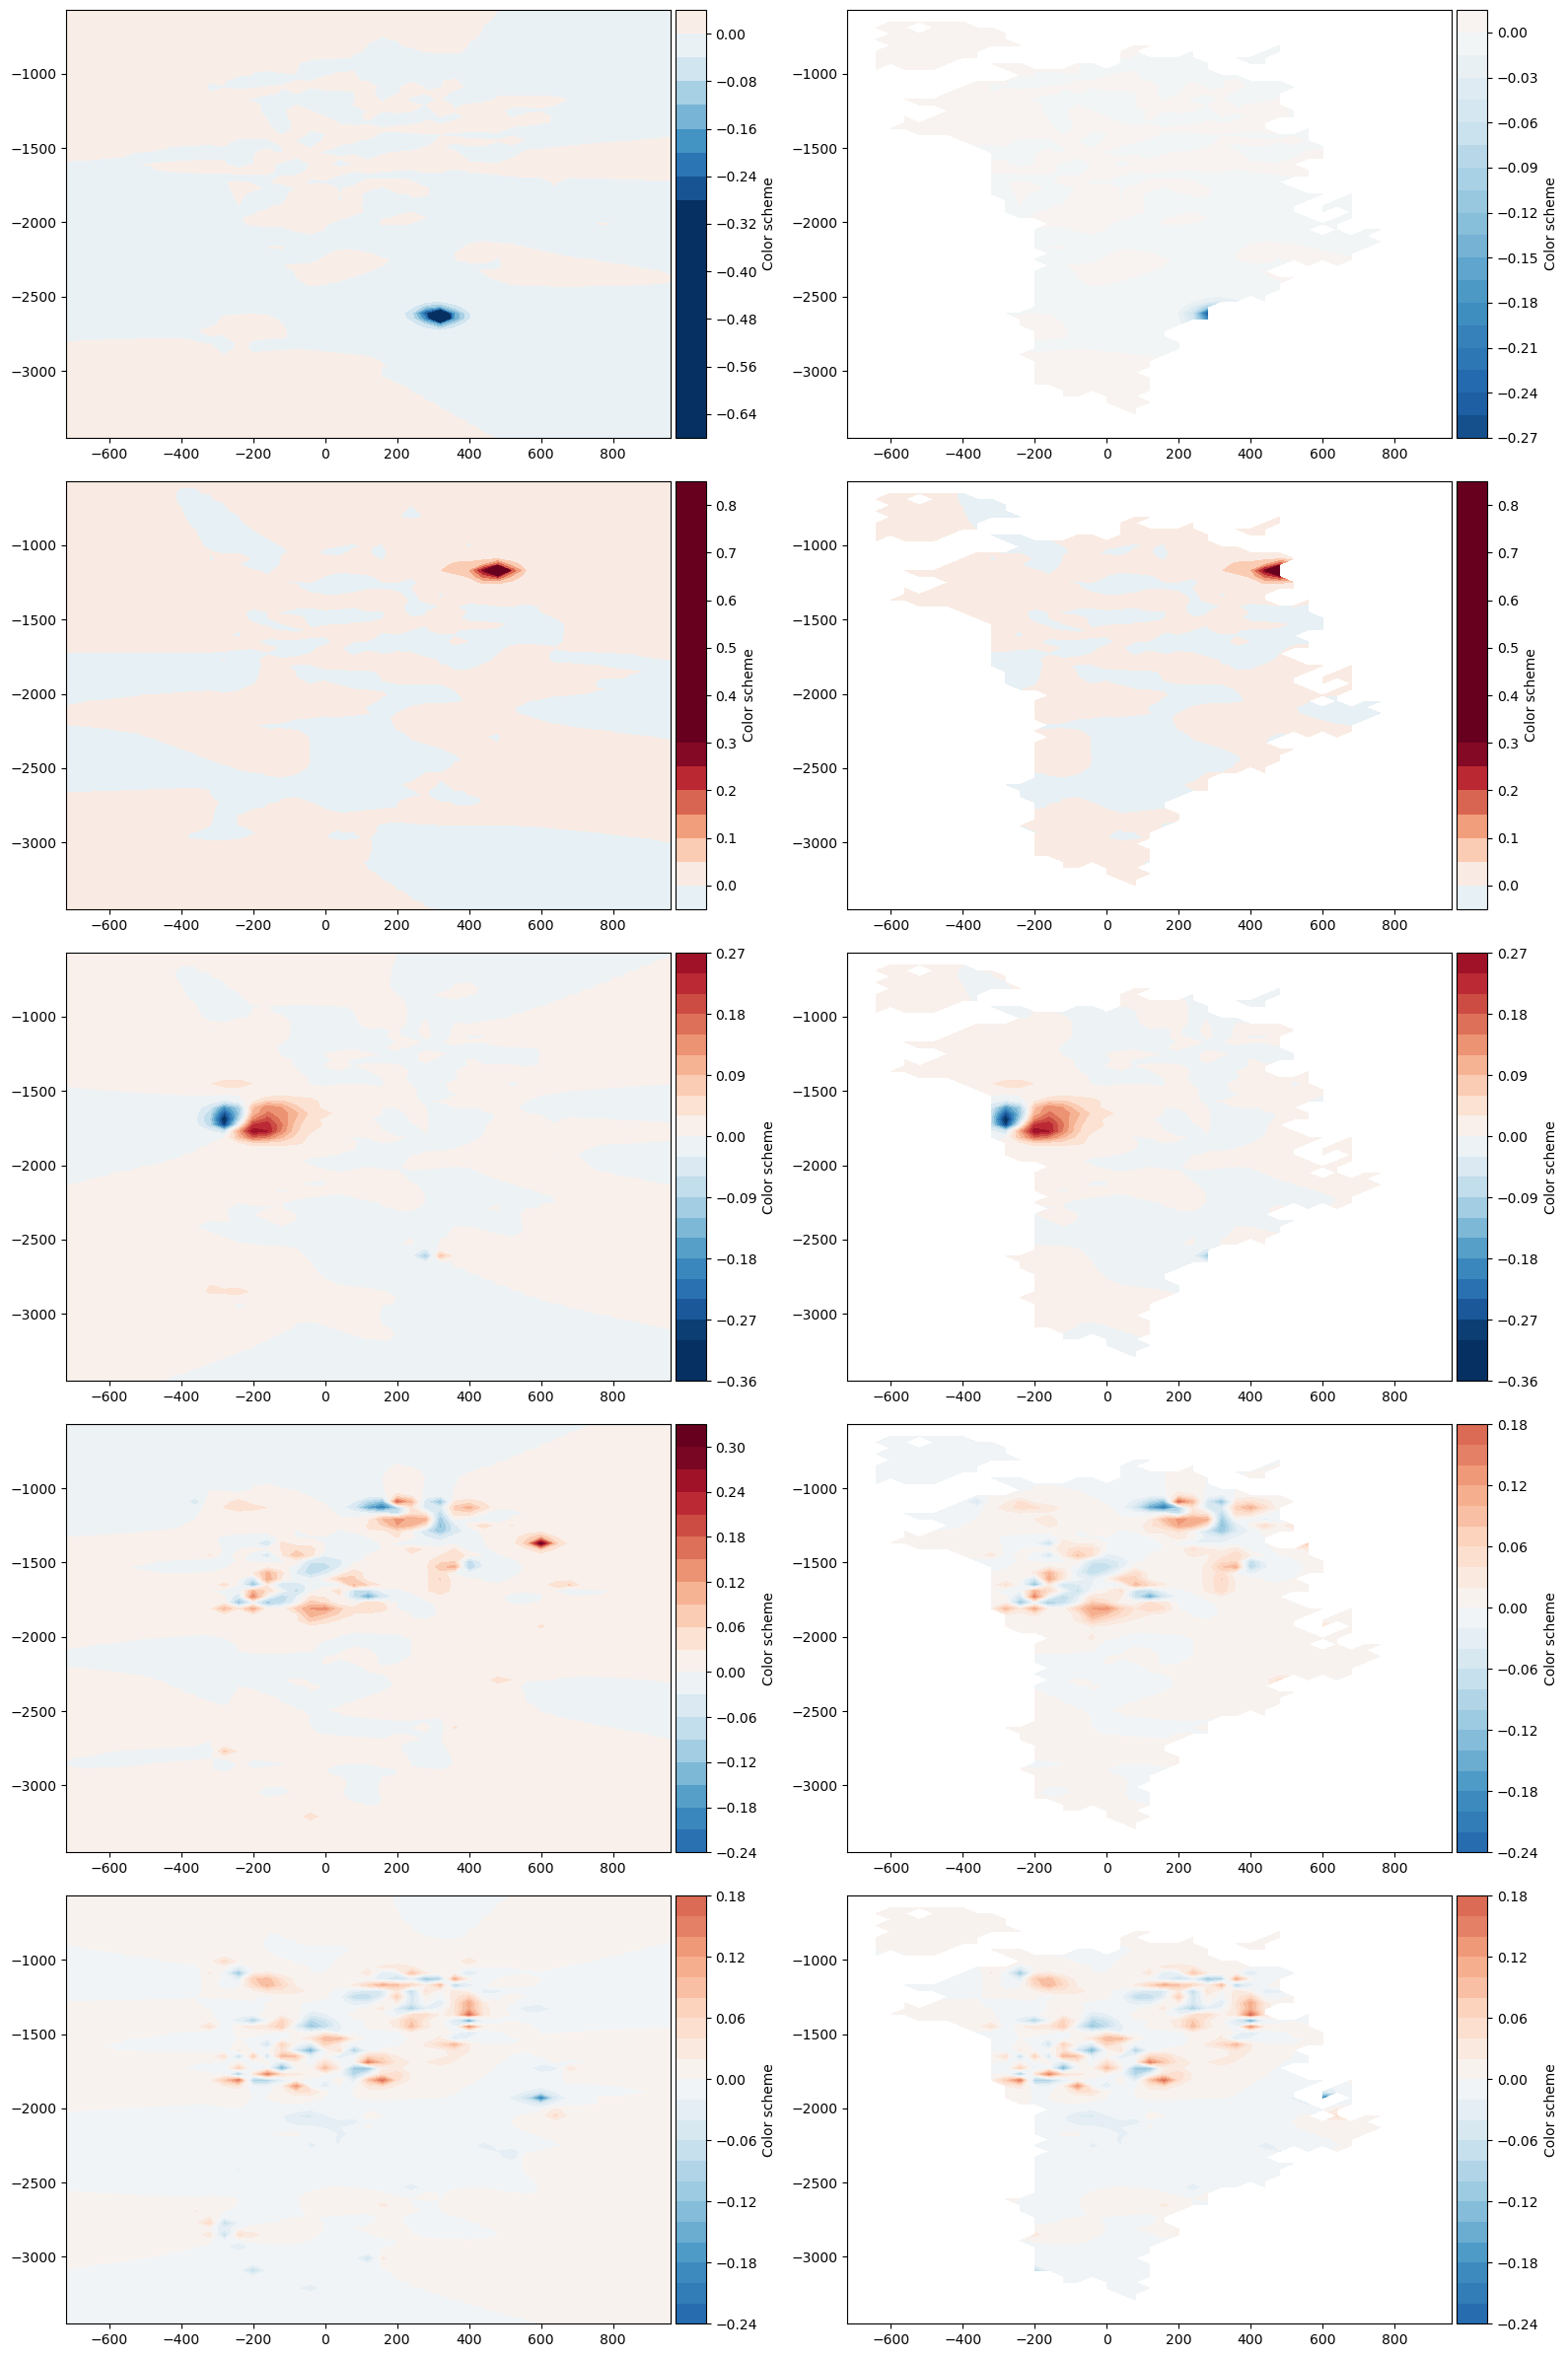

In [15]:
U_misfit_reshaped = np.reshape(U_misfit, (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(5, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 50],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 50]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[4, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[4, 1])
plt.tight_layout()

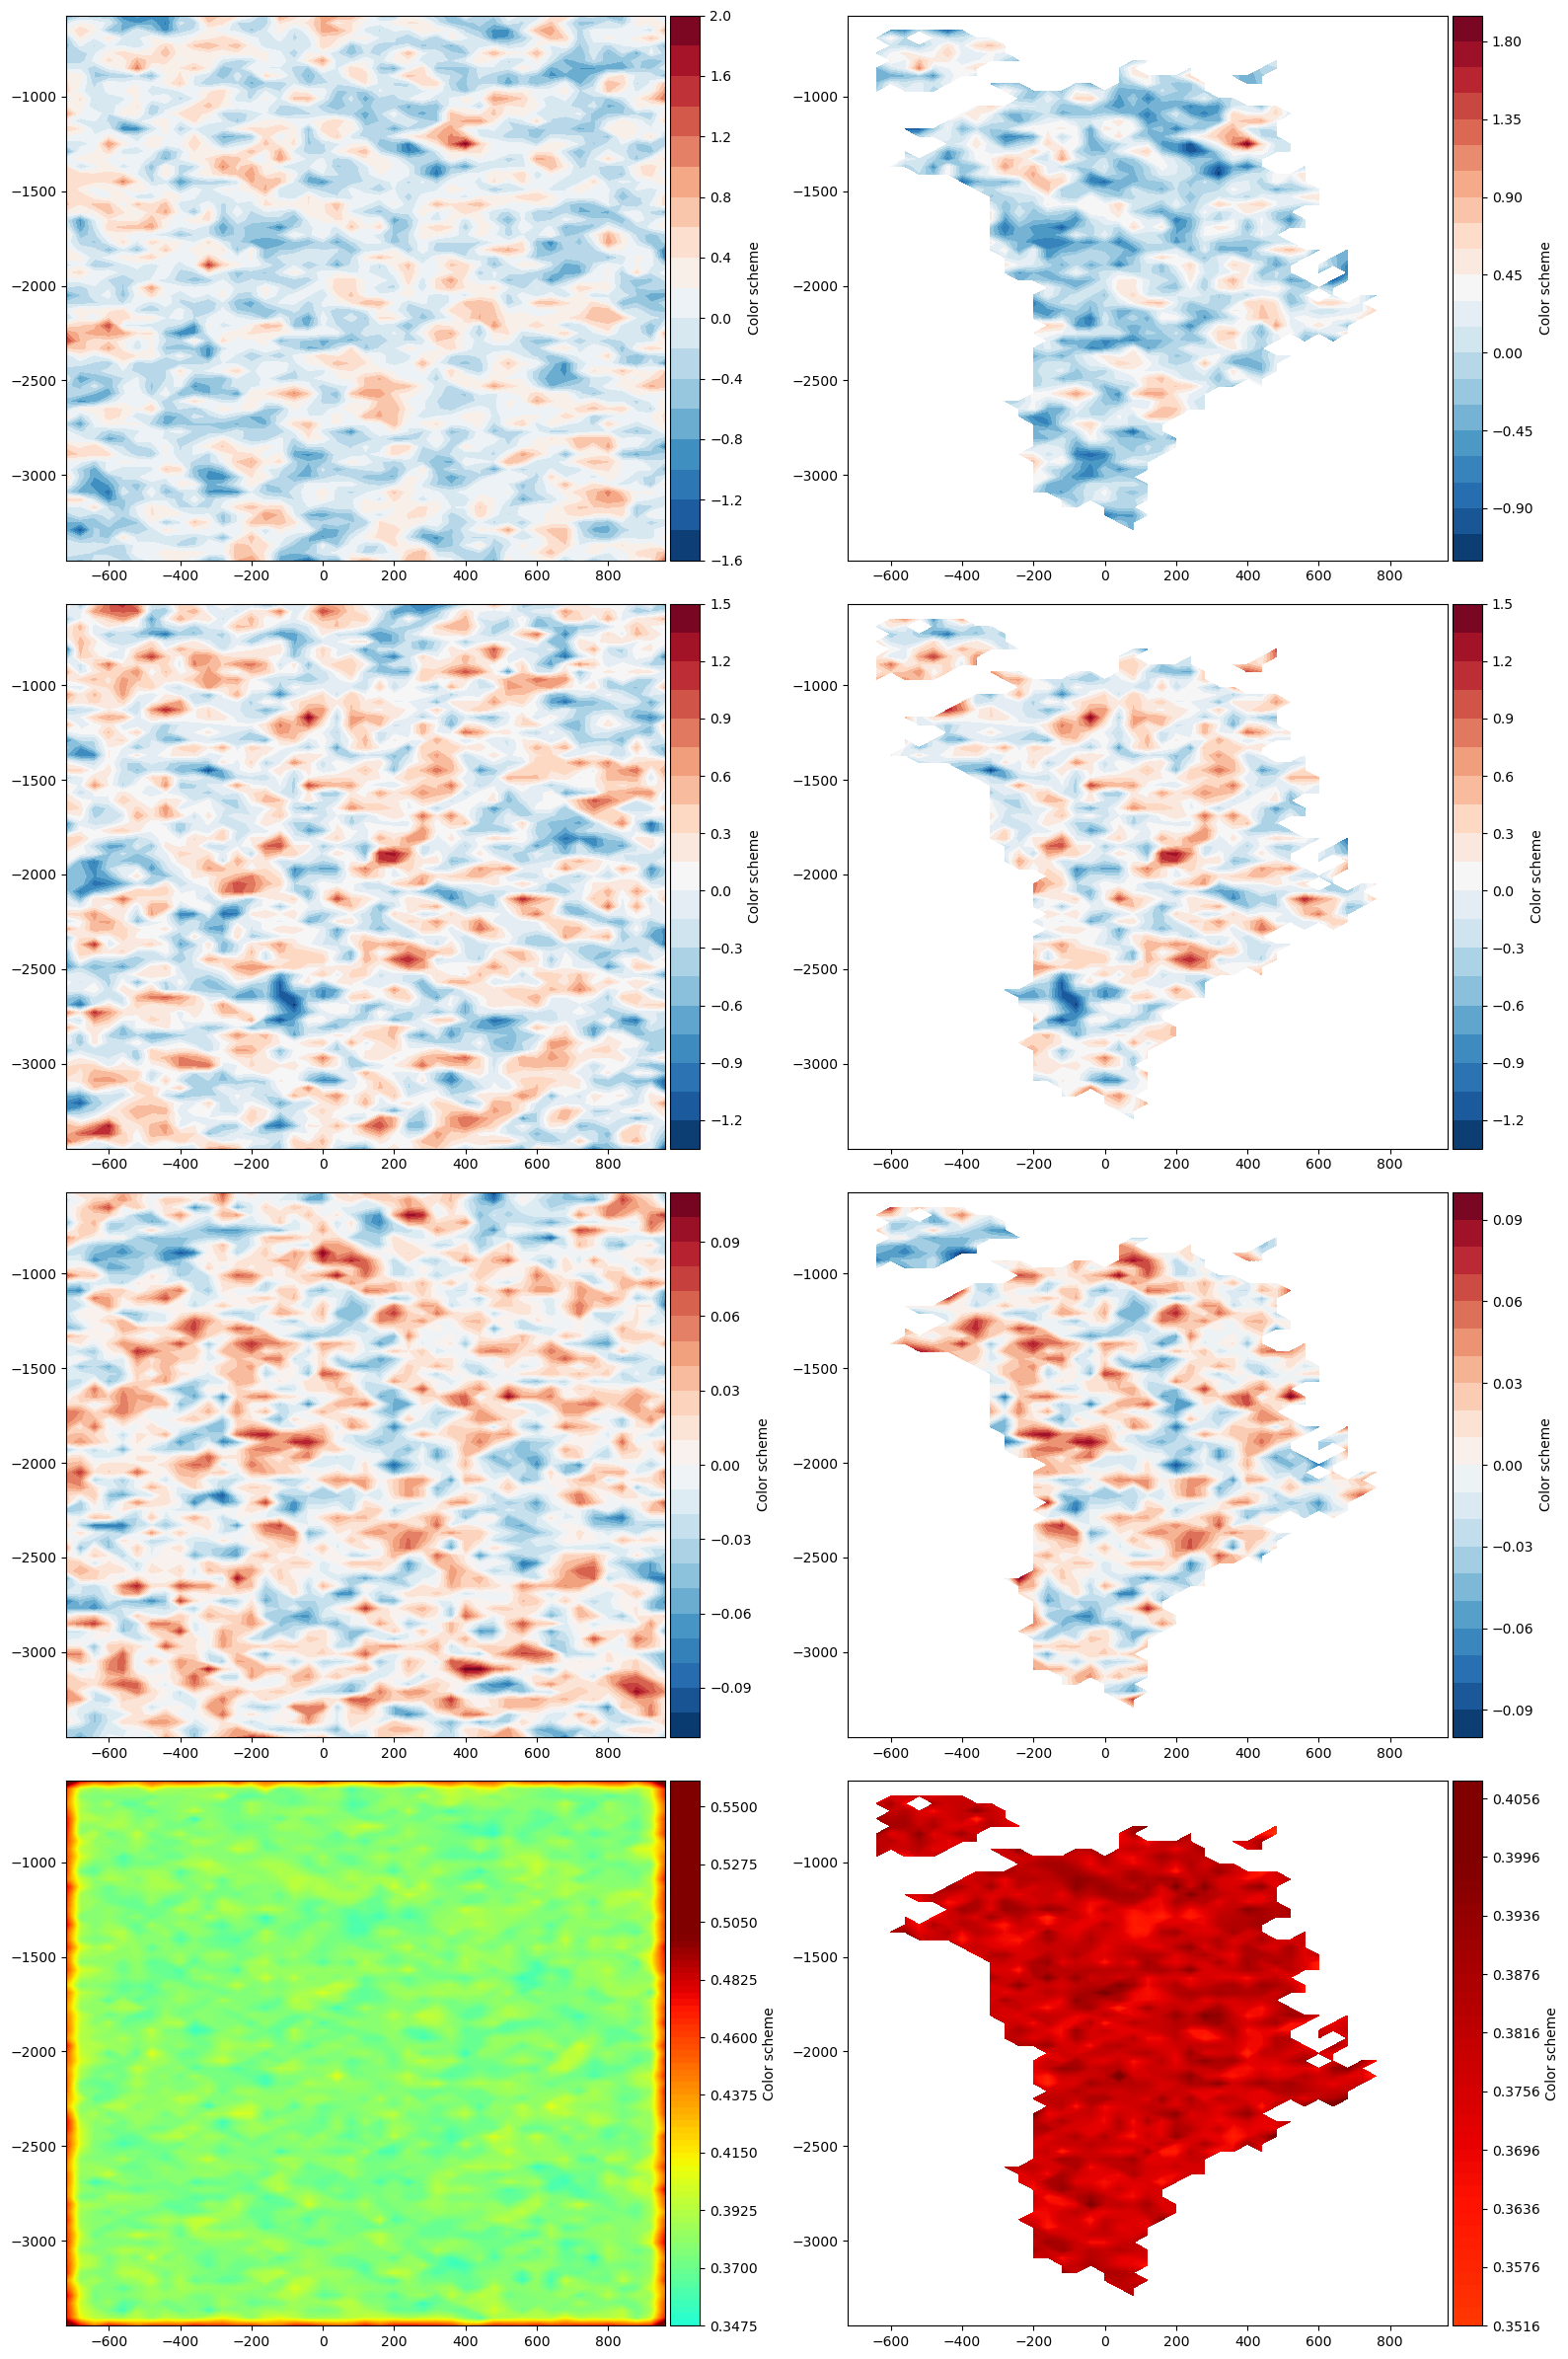

In [16]:
ds_subset_sample_prior_1 = DA.sample_prior()
ds_subset_sample_prior_2 = DA.sample_prior()
ds_mean_samples_prior, ds_std_samples_prior = DA.pointwise_marginals("prior", 1000)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(4, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, vmin = 0.25, vmax = 0.5, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, vmin = 0.076, vmax = 0.4, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [ ]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit, Lambda_misfit)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit, Lambda_misfit)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 1000, U_misfit, Lambda_misfit)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(4, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, vmin = 0.25, vmax = 0.5, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, vmin = 0.076, vmax = 0.4, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [ ]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

DA.l_bfgs(5, 3)